<a href="https://colab.research.google.com/github/MilindiSenevirathne/COVID-19_Test/blob/main/Outbreak_Detection_using_Spatial_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [194]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from IPython.display import FileLink
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import plotly.express as px
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import silhouette_score
from datetime import datetime

In [168]:
df = pd.read_csv('/content/sample_data/full_grouped.csv', sep = r'\s*,\s*', engine = 'python')
df.head()

Date      Country  Confirmed  Deaths  Recovered  Active  New cases  \
0  1/22/2020  Afghanistan          0       0          0       0          0   
1  1/22/2020      Albania          0       0          0       0          0   
2  1/22/2020      Algeria          0       0          0       0          0   
3  1/22/2020      Andorra          0       0          0       0          0   
4  1/22/2020       Angola          0       0          0       0          0   

   New deaths  New recovered             WHO Region  Latitude  Longitude  \
0           0              0  Eastern Mediterranean       NaN        NaN   
1           0              0                 Europe       NaN        NaN   
2           0              0                 Africa       NaN        NaN   
3           0              0                 Europe       NaN        NaN   
4           0              0                 Africa       NaN        NaN   

   Population  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN

In [169]:
country_location = pd.read_csv('/content/sample_data/location.csv', sep = r'\s*,\s*', engine = 'python')
country_location.head()

Country   Latitude  Longitude
0  Afghanistan  33.939110  67.709953
1      Albania  41.153332  20.168331
2      Algeria  28.033886   1.659626
3      Andorra  42.506285   1.521801
4       Angola -11.202692  17.873887

In [170]:
# Merge the 'country_location' DataFrame into 'df' based on the 'Country' column
df = pd.merge(df, country_location, on='Country', how='left', suffixes=('', '_new'))
df['Latitude'] = df['Latitude'].fillna(df['Latitude_new'].to_dict())
df['Longitude'] = df['Longitude'].fillna(df['Longitude_new'].to_dict())
df.drop(['Latitude_new', 'Longitude_new'], axis=1, inplace=True)
df.head()

Date      Country  Confirmed  Deaths  Recovered  Active  New cases  \
0  1/22/2020  Afghanistan          0       0          0       0          0   
1  1/22/2020      Albania          0       0          0       0          0   
2  1/22/2020      Algeria          0       0          0       0          0   
3  1/22/2020      Andorra          0       0          0       0          0   
4  1/22/2020       Angola          0       0          0       0          0   

   New deaths  New recovered             WHO Region   Latitude  Longitude  \
0           0              0  Eastern Mediterranean  33.939110  67.709953   
1           0              0                 Europe  41.153332  20.168331   
2           0              0                 Africa  28.033886   1.659626   
3           0              0                 Europe  42.506285   1.521801   
4           0              0                 Africa -11.202692  17.873887   

   Population  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN

In [171]:
population = pd.read_csv('/content/sample_data/population_by_country_2020.csv')
population.head()

Country  Population
0          China  1440297825
1          India  1382345085
2  United States   331341050
3      Indonesia   274021604
4       Pakistan   221612785

In [172]:
# Merge the 'population' DataFrame into 'df' based on the 'Country' column
df = pd.merge(df, population, on='Country', how='left', suffixes=('', '_new'))
df['Population'] = df['Population'].fillna(df['Population_new'].to_dict())
df.drop(['Population_new'], axis=1, inplace=True)
df.head()

Date      Country  Confirmed  Deaths  Recovered  Active  New cases  \
0  1/22/2020  Afghanistan          0       0          0       0          0   
1  1/22/2020      Albania          0       0          0       0          0   
2  1/22/2020      Algeria          0       0          0       0          0   
3  1/22/2020      Andorra          0       0          0       0          0   
4  1/22/2020       Angola          0       0          0       0          0   

   New deaths  New recovered             WHO Region   Latitude  Longitude  \
0           0              0  Eastern Mediterranean  33.939110  67.709953   
1           0              0                 Europe  41.153332  20.168331   
2           0              0                 Africa  28.033886   1.659626   
3           0              0                 Europe  42.506285   1.521801   
4           0              0                 Africa -11.202692  17.873887   

   Population  
0  39074280.0  
1   2877239.0  
2  43984569.0  
3     77287.0  
4  33032075.0

In [173]:
df.isnull().sum()

Date                0
Country             0
Confirmed           0
Deaths              0
Recovered           0
Active              0
New cases           0
New deaths          0
New recovered       0
WHO Region          0
Latitude            0
Longitude           0
Population       2256
dtype: int64

In [174]:
df.dropna(subset=['Population'], inplace=True)

In [175]:
df.isnull().sum()

Date             0
Country          0
Confirmed        0
Deaths           0
Recovered        0
Active           0
New cases        0
New deaths       0
New recovered    0
WHO Region       0
Latitude         0
Longitude        0
Population       0
dtype: int64

In [176]:
df = df.drop(['WHO Region'], axis=1)

In [177]:
df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(
    df.Longitude, df.Latitude
))

In [178]:
# Standardizing numerical data
scaler = StandardScaler()
df[['Confirmed', 'Deaths', 'Recovered', 'Active', 'New cases', 'New deaths', 'New recovered', 'Population']] = scaler.fit_transform(df[['Confirmed', 'Deaths', 'Recovered', 'Active', 'New cases', 'New deaths', 'New recovered', 'Population']])

In [179]:
df.head()

Date      Country  Confirmed    Deaths  Recovered    Active  \
0  1/22/2020  Afghanistan  -0.211766 -0.205168  -0.179036 -0.232176   
1  1/22/2020      Albania  -0.211766 -0.205168  -0.179036 -0.232176   
2  1/22/2020      Algeria  -0.211766 -0.205168  -0.179036 -0.232176   
3  1/22/2020      Andorra  -0.211766 -0.205168  -0.179036 -0.232176   
4  1/22/2020       Angola  -0.211766 -0.205168  -0.179036 -0.232176   

   New cases  New deaths  New recovered   Latitude  Longitude  Population  \
0  -0.175692    -0.17595      -0.130233  33.939110  67.709953   -0.013919   
1  -0.175692    -0.17595      -0.130233  41.153332  20.168331   -0.249741   
2  -0.175692    -0.17595      -0.130233  28.033886   1.659626    0.018071   
3  -0.175692    -0.17595      -0.130233  42.506285   1.521801   -0.267982   
4  -0.175692    -0.17595      -0.130233 -11.202692  17.873887   -0.053284   

                     geometry  
0   POINT (67.70995 33.93911)  
1   POINT (20.16833 41.15333)  
2    POINT (1.65963 28.03389)  
3    POINT (1.52180 42.50628)  
4  POINT (17.87389 -11.20269)

<ipython-input-182-0849480c562b>:1: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr(method='pearson')


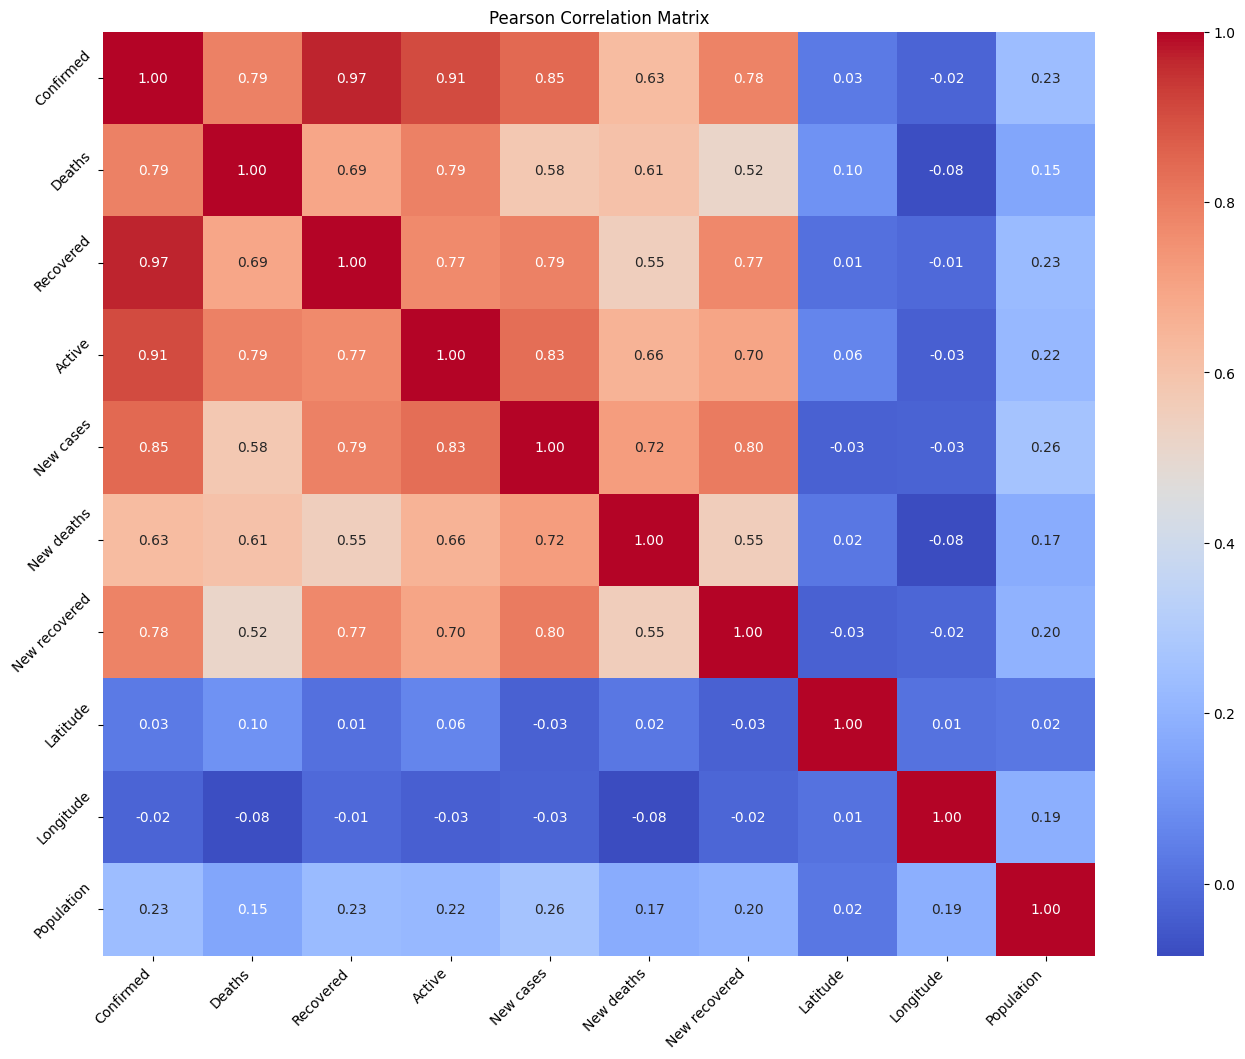

In [182]:
correlation_matrix = df.corr(method='pearson')

plt.figure(figsize=(16, 12))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={'size': 10})
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45)

plt.title('Pearson Correlation Matrix')
plt.show()

In [185]:
df = df.drop(['Deaths', 'Recovered', 'Active', 'New cases', 'New deaths', 'New recovered'], axis=1)
df.head()

Date      Country  Confirmed   Latitude  Longitude  Population  \
0  1/22/2020  Afghanistan  -0.211766  33.939110  67.709953   -0.013919   
1  1/22/2020      Albania  -0.211766  41.153332  20.168331   -0.249741   
2  1/22/2020      Algeria  -0.211766  28.033886   1.659626    0.018071   
3  1/22/2020      Andorra  -0.211766  42.506285   1.521801   -0.267982   
4  1/22/2020       Angola  -0.211766 -11.202692  17.873887   -0.053284   

                     geometry  
0   POINT (67.70995 33.93911)  
1   POINT (20.16833 41.15333)  
2    POINT (1.65963 28.03389)  
3    POINT (1.52180 42.50628)  
4  POINT (17.87389 -11.20269)

<ipython-input-192-293acc4e888d>:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


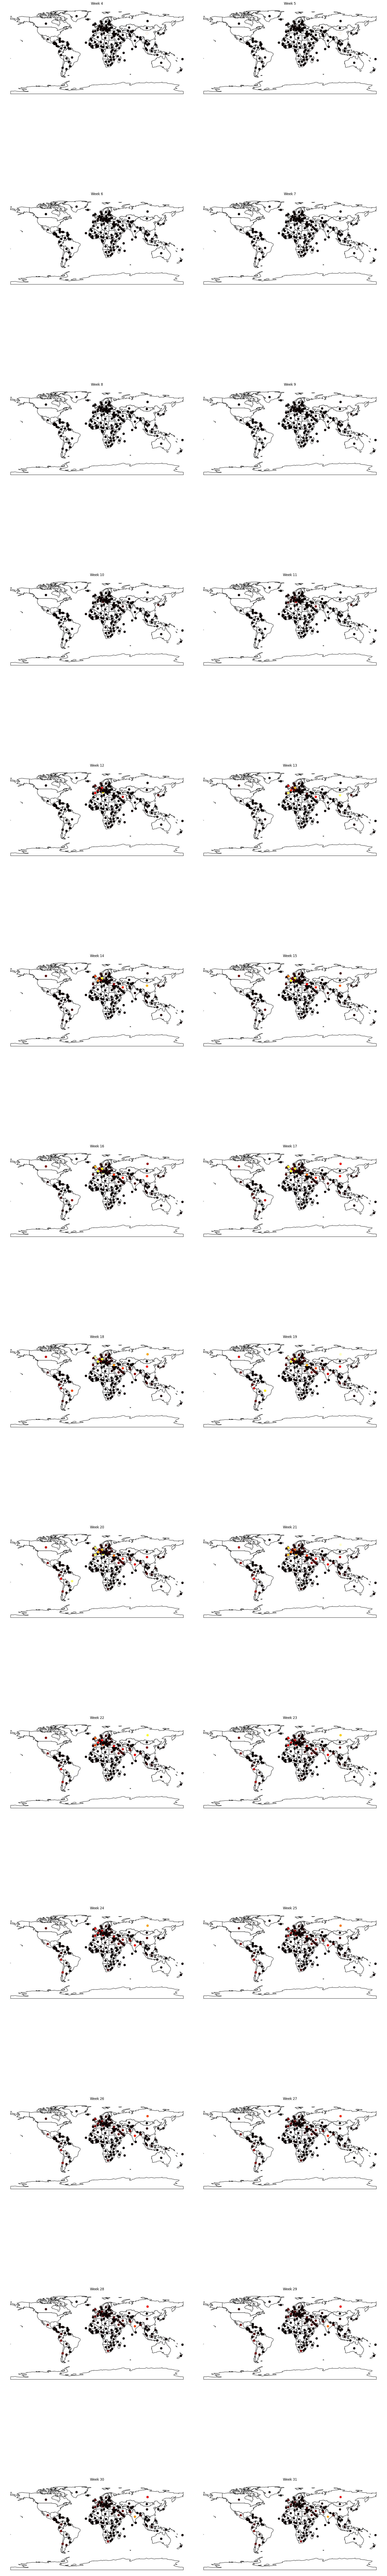

In [192]:
df['Date'] = pd.to_datetime(df['Date'])
df['Week'] = df['Date'].dt.isocalendar().week

# Load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Group by week
weeks = df.groupby('Week')
num_weeks = weeks.ngroups
rows = (num_weeks + 1) // 2  # Two weeks per row

# Create subplots
fig, axs = plt.subplots(rows, 2, figsize=(20, rows * 10))  # Adjust figure size as needed

for (week, group), ax in zip(weeks, axs.flatten()):
    gdf = gpd.GeoDataFrame(group, geometry=gpd.points_from_xy(group.Longitude, group.Latitude))
    world.plot(ax=ax, color='white', edgecolor='black')
    gdf.plot(ax=ax, column='Confirmed', cmap='hot', markersize=50)  # Adjust markersize
    ax.set_title(f'Week {week}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [205]:
weekly_stats = df.groupby('Week').agg(
    Mean_Confirmed=('Confirmed', 'mean'),
    Std_Dev_Confirmed=('Confirmed', 'std'),
    Cumulative_Confirmed=('Confirmed', 'sum')
)

# Calculate Incidence Rate (per 100,000) - Assuming 'Population' column is per country
# and 'Confirmed' is the number of new cases in that week
weekly_stats['Incidence_Rate'] = (weekly_stats['Cumulative_Confirmed'] / df['Population'].mean()) * 100000

# Calculate Growth Rate
weekly_stats['Growth_Rate'] = weekly_stats['Cumulative_Confirmed'].pct_change().fillna(0)

weekly_stats.reset_index(inplace=True)

date_range = df.groupby('Week')['Date'].agg(['first', 'last']).reset_index()

new_df = pd.merge(date_range, weekly_stats, on='Week')
new_df.rename(columns={'first': 'From Date', 'last': 'To Date'}, inplace=True)
new_df.head()

Week  From Date    To Date  Mean_Confirmed  Std_Dev_Confirmed  \
0     4 2020-01-22 2020-01-26       -0.211691           0.001095   
1     5 2020-01-27 2020-02-02       -0.211184           0.008463   
2     6 2020-02-03 2020-02-09       -0.209746           0.027124   
3     7 2020-02-10 2020-02-16       -0.207981           0.050681   
4     8 2020-02-17 2020-02-23       -0.206751           0.065656   

   Cumulative_Confirmed  Incidence_Rate  Growth_Rate  
0           -185.229641    2.174737e+24     0.000000  
1           -258.700392    3.037340e+24     0.396647  
2           -256.939194    3.016662e+24    -0.006808  
3           -254.776552    2.991271e+24    -0.008417  
4           -253.269864    2.973581e+24    -0.005914

In [208]:
new_df.replace([np.inf, -np.inf], np.nan, inplace=True)

new_df.fillna(new_df.mean(), inplace=True)

scaler = StandardScaler()
new_df_scaled = scaler.fit_transform(new_df.drop(['Week', 'From Date', 'To Date'], axis=1))

pca = PCA(n_components=2)
pca_result = pca.fit_transform(new_df_scaled)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

new_df['PCA1'] = pca_result[:, 0]
new_df['PCA2'] = pca_result[:, 1]
new_df.head()

<ipython-input-208-df63b9b596e3>:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  new_df.fillna(new_df.mean(), inplace=True)
<ipython-input-208-df63b9b596e3>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  new_df.fillna(new_df.mean(), inplace=True)


Week  From Date    To Date  Mean_Confirmed  Std_Dev_Confirmed  \
0     4 2020-01-22 2020-01-26       -0.211691           0.001095   
1     5 2020-01-27 2020-02-02       -0.211184           0.008463   
2     6 2020-02-03 2020-02-09       -0.209746           0.027124   
3     7 2020-02-10 2020-02-16       -0.207981           0.050681   
4     8 2020-02-17 2020-02-23       -0.206751           0.065656   

   Cumulative_Confirmed  Incidence_Rate  Growth_Rate      PCA1      PCA2  
0           -185.229641    2.174737e+24     0.000000 -1.570966 -0.181069  
1           -258.700392    3.037340e+24     0.396647 -1.793284 -0.734507  
2           -256.939194    3.016662e+24    -0.006808 -1.814694 -0.151588  
3           -254.776552    2.991271e+24    -0.008417 -1.788772 -0.145878  
4           -253.269864    2.973581e+24    -0.005914 -1.771225 -0.147306

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

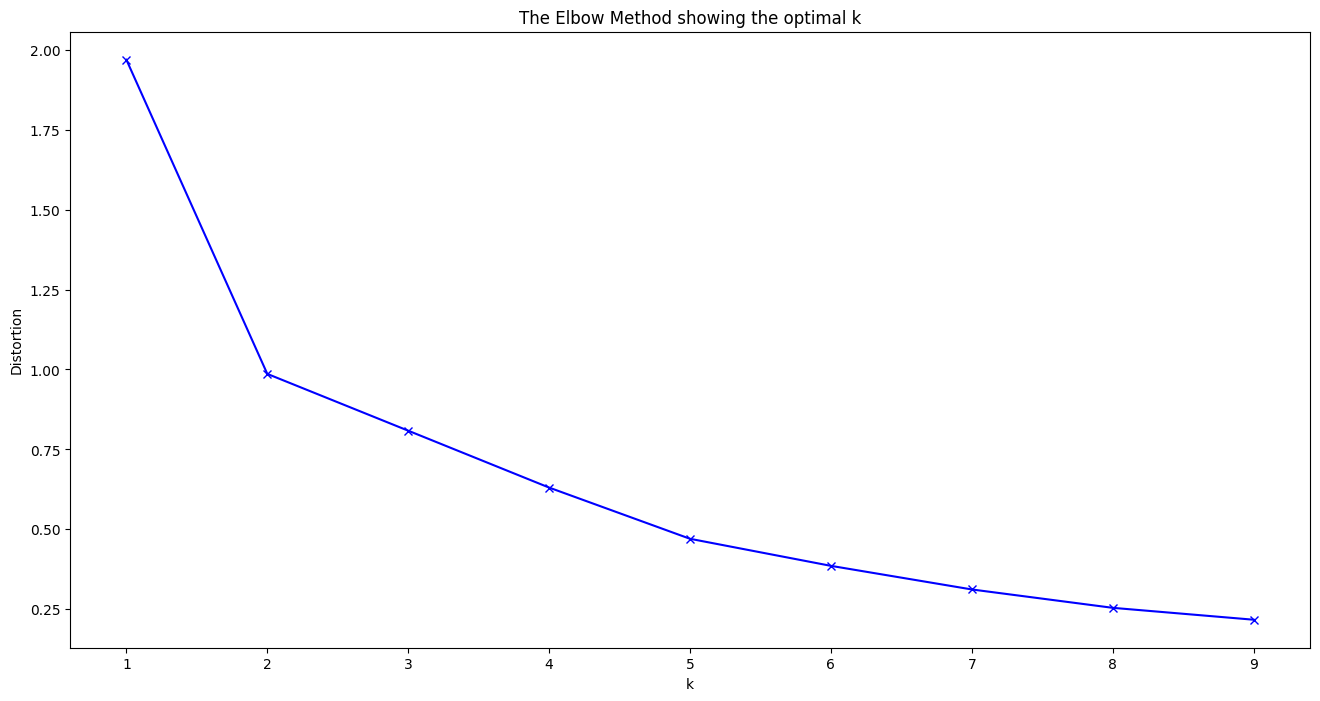

In [209]:
distortions = []
K = range(1, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(new_df[['PCA1', 'PCA2']])
    distortions.append(sum(np.min(cdist(new_df[['PCA1', 'PCA2']], kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / new_df[['PCA1', 'PCA2']].shape[0])

# Plot the elbow
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For K-Means, the average silhouette_score is : 0.5824301144581117
Outlier Week: [22, 23, 24, 25, 26]


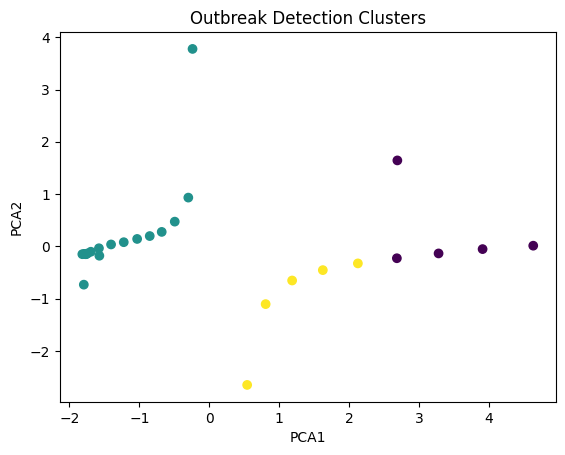

In [214]:
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(new_df[['PCA1', 'PCA2']])

new_df['Cluster'] = clusters

silhouette_avg_kmeans = silhouette_score(new_df[['PCA1', 'PCA2']], kmeans.labels_)
print("For K-Means, the average silhouette_score is :", silhouette_avg_kmeans)


outlier_cluster = new_df['Cluster'].value_counts().idxmin()
outlier_countries = new_df[new_df['Cluster'] == outlier_cluster]['Week'].tolist()
print("Outlier Week:", outlier_countries)

# Plot the clusters
plt.scatter(new_df['PCA1'], new_df['PCA2'], c=new_df['Cluster'], cmap='viridis')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Outbreak Detection Clusters')
plt.show()